In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# reading names file
words = open('names.txt', 'r').read().splitlines()

In [3]:
# mappings from integers to strings and vv
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
# build dataset with train and test split
block_size = 3 # how many chars taken to predict the next char
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [36]:
# revisted MLP
n_embd = 10 #dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer

# best way to init NN is to multiply weights by the sqrt of fan_in
# fan_in = num input neurons
# this is because it will keep the std of the distribution at 1
# calculated here
std = (5/3) / ((n_embd * block_size) ** 0.5)

g = torch.Generator().manual_seed(2147483647)
# lookup table
C = torch.randn((vocab_size, n_embd),             generator=g)
# layer with n_embd * block_size inputs into n_hidden neurons (outputs). Squashes weights to bring hpreact values closer to 0
# squashing W1 and b1 helps with the dead neuron problem below. This helps because if it brings hpreact closer to 0, that means
# when it is run through tanh, it will be further from the tails making it less likely to output -1 or 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * std #* 0.2
# biases for each neuron in l1. Brings biases closer to 0 but not 0, adds some entropy
# when using batch normalization, biases are not needed since they will be subtracted out later
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# layer with n_hidden inputs (from the outputs of last layer) and vocab_size neurons (outputs). Scaled down to 0.01 in order to lower initial loss
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# biases for each neuron in l2. Init to all 0, this helps with initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12297


In [37]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct. Makes training faster / more efficient
    # splits training data into bacthes and only forward / backward passes for each batch instead on for every sample
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # taking 32 rows of X at a time
    # approximates gradients and takes more steps in grad. descent rather than calculating exact grad and taking less steps
    Xb, Yb = Xtr[ix], Ytr[ix] # X and Y batches
    
    # forward pass
    emb = C[Xb] # embedded training data. Makes it easier for NN to understand
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    # hidden layer pre-activation. 
    # Bias is commented for reason stated in init. Leaving b1 in won't change anything but it's wasteful
    hpreact = embcat @ W1 # + b1
    
    # batch normalization -------------------------------------------------------------------------------------------------
    # goal here is to change hpreact to a more gaussian distribution. This keeps the tanh function in the active part
    # bngain and bnbias allow the NN to move around this distribution allowing it to become more / less gaussian if needed
    # at init the batch will be exactly unit gaussian (std of 1). As training continues, this will change
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    # estimates mean / std over whole set. This is so you can sample from NN without it expecting a batch input.
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------------------------------------------------------------------------------------
    
    h = torch.tanh(hpreact) # hidden layer outputs
    logits = h @ W2 + b2 # l2 output before activation. L1 output * weights2 + biases2
    loss = F.cross_entropy(logits, Yb) # output layer activation & loss
    
    # backward pass
    for p in parameters:
        p.grad = None # always set gradients to none before a backward pass so they don't keep stacking and inflate learning rate
    loss.backward()
    
    # update params
    lr = 0.1 if i < 100000 else 0.01  # switches learning rate at 100000 steps in order to be more accurate
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracks stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # prints loss every 10000 steps
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [22]:
# expected loss at init
# there are 27 possible chars so the probability that it chooses the right char at the beginning is 1/27
# the loss is the -log of that probability so below is the expected init loss
-torch.tensor(1/27).log()

tensor(3.2958)

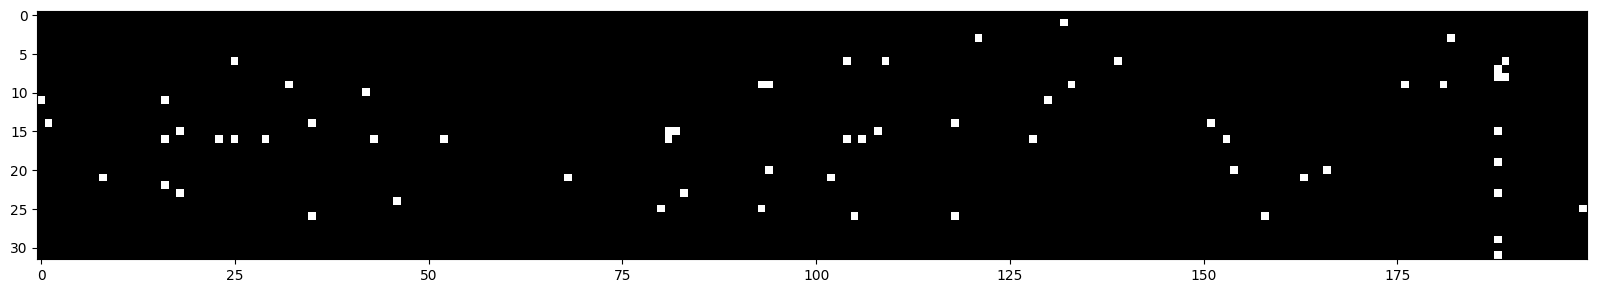

In [22]:
# for all white spaces, the gradient is being destroyed during backprop
# this is because all of the white spaces show that the hidden layer outputs -1 or 1
# for tanh this means there is a 1 - 1 = 0 during backprop causing the gradient to be ignored and not changed
# if the whole column is white, that means for every sample, the tanh will output -1 or 1, causing a dead neuron
# dead neuron means the backprop will never change that weight causing it to never learn
# the same can happen for sigmoid and ReLU
# all of these white spaces mean less training for each of these neurons because those mean that backprop isn't changing grad

# after squashing W1 and b1, the whole map is black, meaning none of the samples output -1 or 1 from tanh
# this is fine but sometimes a few white spots isnt bad. So raising W1 squashing could help

# after raising W1 squashing from 0.1 to 0.2 there is some white, this is probably better than all black
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

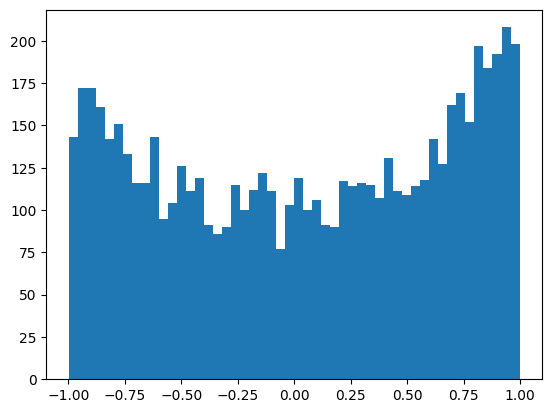

In [23]:
# you can see here how the majority of h outputs are -1 or 1

# after squashing W1 and b1 the values are a much better distribution with a lot less toward the middle and not at -1 or 1
plt.hist(h.view(-1).tolist(), 50);

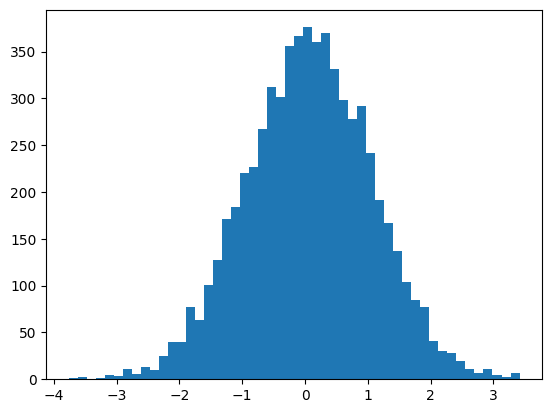

In [24]:
# the above is caused because the pre activation values are between -20 and 20, 
#causing the tanh function to be in one of the tails

# removing sqashing of W1 and b1 from MLP init will return this spread back to -20, 20
plt.hist(hpreact.view(-1).tolist(), 50);

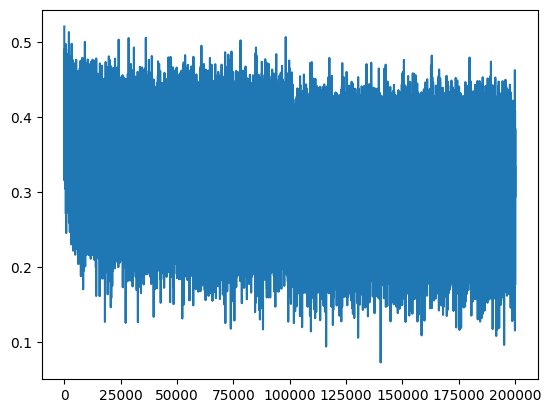

In [27]:
plt.plot(lossi) # plots loss over steps

In [35]:
# disables gradient tracking which is not needed for validation
# this is because there will be no backward pass so torch doesnt have to track grads
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [29]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass of NN. Returns a prob distribution for the next char
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # recording char linked to highest prob
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        # ends if sample == '.'
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


In [ ]:
# CONVERTING TO PyTorch ------------------------------------------------------------------------------------------------

In [43]:
# linear (dense) layer in pytorch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    # calculates w @ x + b
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    # returns num of params
    @property
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# batch normalization layer
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params; trained during backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers; trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalization
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + running_momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + running_momentum * xvar
        return self.out
    
    @property
    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    @property
    def parameters(self):
        return []
    
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [44]:
# pretty much same opt as above
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad() # take this out after debug
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # prints loss every 10000 steps
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3058


layer 1 (      Tanh): mean +0.02, std 0.71, saturated: 14.19%
layer 3 (      Tanh): mean +0.03, std 0.68, saturated: 8.03%
layer 5 (      Tanh): mean -0.03, std 0.67, saturated: 7.06%
layer 7 (      Tanh): mean +0.01, std 0.66, saturated: 5.59%
layer 9 (      Tanh): mean -0.00, std 0.66, saturated: 6.47%


Text(0.5, 1.0, 'activation distribution')

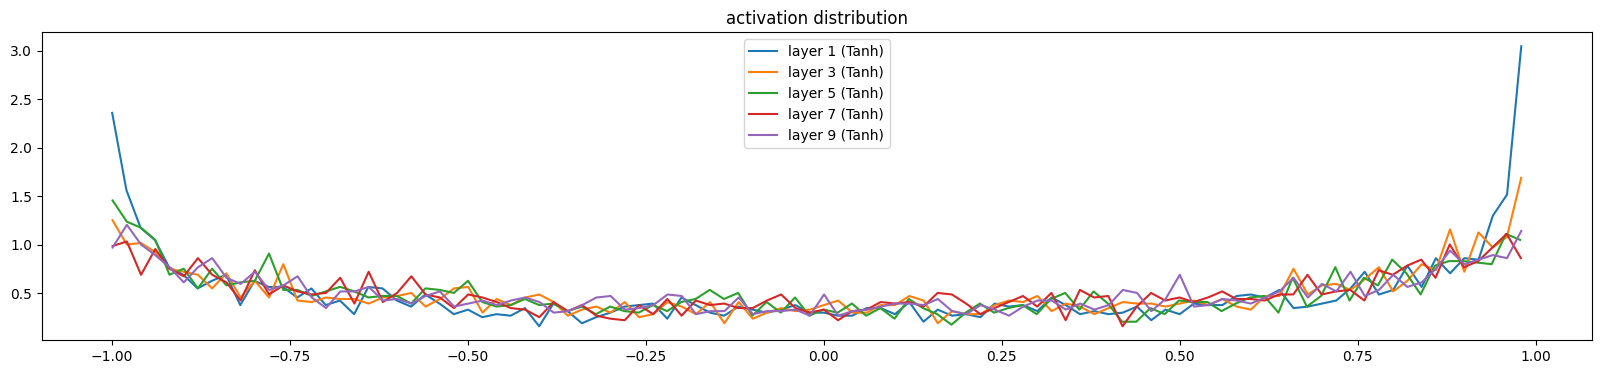

In [46]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution')